In [1]:
!pip install tensorflow-gpu
!pip install keras
!pip install plotly
!pip install cufflinks
!pip install chart_studio


     |████████████████████████████████| 380.8MB 43kB/s 
     |████████████████████████████████| 3.8MB 29.2MB/s 
     |████████████████████████████████| 450kB 35.7MB/s 
     |████████████████████████████████| 81kB 9.0MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.0.2 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
ERROR: tensorboard 2.0.2 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.7.1 which is incompatible.
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existi

In [2]:
#Imports

import tensorflow
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, GRU, Flatten
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
import re
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
#STOPWORDS = set(stopwords.words('english'))
#import chart_studio.plotly.graph_objs as go
import chart_studio.plotly as py
import cufflinks
from IPython.core.interactiveshell import InteractiveShell
#import chart_studio.plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
#from chart_studio.plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

Using TensorFlow backend.


In [3]:
from nltk.tokenize import RegexpTokenizer
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [4]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

TensorFlow is already loaded. Please restart the runtime to change versions.


<tf.Tensor: id=35, shape=(), dtype=float32, numpy=-920.36035>

<tf.Tensor: id=70, shape=(), dtype=float32, numpy=6179.3096>

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
4.57642328999998
GPU (s):
0.2133589129999791
GPU speedup over CPU: 21x


In [5]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10430975562286674689, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 4336678271985388837
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 11169470224896045882
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11330115994
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 12786072097296711783
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [0]:
STOPWORDS = stopwords

In [0]:
#Reading in data

df = pd.read_csv('df_mc_cut.csv')
df.drop(columns = 'Unnamed: 0', inplace = True)

In [9]:

df.head()

,title,type
0,Water Cooler 1/25/18 Open Thread; Fake News ? ...,fake
1,"Lost Words, Hidden Words, Otters, Banks and Books",fake
2,Red Alert: Bond Yields Are SCREAMING “Inflatio...,fake
3,Scientists move Doomsday Clock ahead by 30 sec...,fake
4,Why Sandwiches Must Be Banned,fake


In [0]:
def tokenize(x):
    tokenizer = RegexpTokenizer(r'\w+')
    return tokenizer.tokenize(x)

df['tokens'] = df['title'].map(tokenize)

def lemmatize(x):
    lemmatizer = nltk.wordnet.WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(word) for word in x])

df['lemma'] = df['tokens'].map(lemmatize)

In [12]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 50
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=False)
tokenizer.fit_on_texts(df['lemma'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 546234 unique tokens.


In [13]:
X = tokenizer.texts_to_sequences(df['lemma'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (3782629, 50)


In [14]:
Y = pd.get_dummies(df['type']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (3782629, 7)


In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(3404366, 50) (3404366, 7)
(378263, 50) (378263, 7)


In [16]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(GRU(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(7, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 100)           5000000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 100)           0         
_________________________________________________________________
gru (GRU)                    (None, 100)               60600     
_________________________________________________________________
dense (Dense)                (None, 7)                 707       
Total params: 5,061,307
Trainable params: 5,061,307
Non-trainable params: 0
_________________________________________________________________
None


In [17]:
epochs = 10
batch_size = 512

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)], verbose=1)

Train on 3063929 samples, validate on 340437 samples
Epoch 1/10
3063929/3063929 [==============================] - 1206s 394us/sample - loss: 0.8423 - accuracy: 0.6875 - val_loss: 0.8703 - val_accuracy: 0.6826
Epoch 2/10
3063929/3063929 [==============================] - 1200s 392us/sample - loss: 0.7383 - accuracy: 0.7251 - val_loss: 0.8275 - val_accuracy: 0.7000
Epoch 3/10
3063929/3063929 [==============================] - 1202s 392us/sample - loss: 0.7020 - accuracy: 0.7383 - val_loss: 0.8173 - val_accuracy: 0.7014
Epoch 4/10
3063929/3063929 [==============================] - 1215s 397us/sample - loss: 0.6799 - accuracy: 0.7466 - val_loss: 0.7950 - val_accuracy: 0.7087
Epoch 5/10
3063929/3063929 [==============================] - 1222s 399us/sample - loss: 0.6628 - accuracy: 0.7527 - val_loss: 0.7925 - val_accuracy: 0.7091
Epoch 6/10
3063929/3063929 [==============================] - 1229s 401us/sample - loss: 0.6508 - accuracy: 0.7574 - val_loss: 0.7964 - val_accuracy: 0.7063
Epoch

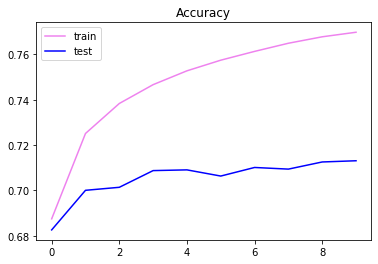

In [18]:

plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train', color = 'violet')
plt.plot(history.history['val_accuracy'], label='test', color = 'blue')
plt.legend()
plt.show();